In [9]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils


def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr, np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate(
            [np.zeros((h, w, 1), dtype=dtype), arr, np.zeros((h, w, 1), dtype=dtype)],
            axis=2,
        )
    return arr


class ColoredMNIST(datasets.VisionDataset):
    """
    Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

    Args:
      root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
      env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
      transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
      target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
    """

    def __init__(
        self, root="./data", env="train1", transform=None, target_transform=None
    ):
        super(ColoredMNIST, self).__init__(
            root, transform=transform, target_transform=target_transform
        )

        self.prepare_colored_mnist()
        if env in ["train1", "train2", "test"]:
            self.data_label_tuples = torch.load(
                os.path.join(self.root, "ColoredMNIST", env) + ".pt"
            )
        elif env == "all_train":
            self.data_label_tuples = torch.load(
                os.path.join(self.root, "ColoredMNIST", "train1.pt")
            ) + torch.load(os.path.join(self.root, "ColoredMNIST", "train2.pt"))
        else:
            raise RuntimeError(
                f"{env} env unknown. Valid envs are train1, train2, test, and all_train"
            )

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, "ColoredMNIST")
        if (
            os.path.exists(os.path.join(colored_mnist_dir, "train1.pt"))
            and os.path.exists(os.path.join(colored_mnist_dir, "train2.pt"))
            and os.path.exists(os.path.join(colored_mnist_dir, "test.pt"))
        ):
            print("Colored MNIST dataset already exists")
            return

        print("Preparing Colored MNIST")
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        test_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f"Converting image {idx}/{len(train_mnist)}")
            im_array = np.array(im)

            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Flip label with 25% probability
            if np.random.uniform() < 0.25:
                binary_label = binary_label ^ 1

            # Color the image either red or green according to its possibly flipped label
            color_red = binary_label == 0

            # Flip the color with a probability e that depends on the environment
            if idx < 20000:
                # 20% in the first training environment
                if np.random.uniform() < 0.2:
                    color_red = not color_red
            elif idx < 40000:
                # 10% in the first training environment
                if np.random.uniform() < 0.1:
                    color_red = not color_red
            else:
                # 90% in the test environment
                if np.random.uniform() < 0.9:
                    color_red = not color_red

            colored_arr = color_grayscale_arr(im_array, red=color_red)

            if idx < 20000:
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 40000:
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                test_set.append((Image.fromarray(colored_arr), binary_label))

            # Debug
        # print('original label', type(label), label)
        # print('binary label', binary_label)
        # print('assigned color', 'red' if color_red else 'green')
        # plt.imshow(colored_arr)
        # plt.show()
        # break

        if not os.path.exists(colored_mnist_dir):
            os.mkdir(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, "train1.pt"))
        torch.save(train2_set, os.path.join(colored_mnist_dir, "train2.pt"))
        torch.save(test_set, os.path.join(colored_mnist_dir, "test.pt"))



In [10]:
maxstep=501
anneal=190
pweight=91257.18613115903
lr=0.0004898536566546834
regweight=0.00110794568
hiddendim=390
exp=2.22

In [11]:

train1 = ColoredMNIST(env="train1", transform=transforms.ToTensor())
train2 = ColoredMNIST(env="train2", transform=transforms.ToTensor())
test = ColoredMNIST(env="test", transform=transforms.ToTensor())
train1loader = torch.utils.data.DataLoader(
    train1, batch_size=20000, shuffle=True, num_workers=0
)
train2loader = torch.utils.data.DataLoader(
    train2, batch_size=20000, shuffle=True, num_workers=0
)
testloader = torch.utils.data.DataLoader(
    test, batch_size=10000, shuffle=False, num_workers=0
)


Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists


In [12]:


class IRM(nn.Module):
    def __init__(self):
        super(IRM, self).__init__()
        lin1 = nn.Linear(3 * 28 * 28, hiddendim)
        lin2 = nn.Linear(hiddendim, hiddendim)
        lin3 = nn.Linear(hiddendim, 1)
        for lin in [lin1, lin2, lin3]:
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
        self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True), lin3)

    def forward(self, x):
        out = x.view(x.shape[0], 3 * 28 * 28)
        out = self._main(out)
        return out





In [14]:

def irm_penalty(logits, y):
        scale = torch.tensor(1.).cuda().requires_grad_()
        loss = F.binary_cross_entropy_with_logits(logits * scale, y)
        grad_ = grad(loss, [scale], create_graph=True)[0]
        return torch.sum(grad_**2)
    
def acc(logits,y):
        preds = (logits > 0.).float()
        return ((preds - y).abs() < 1e-2).float().mean() 

def update(net, all_x, all_y):
        all_y = all_y.view(all_y.shape[0], 1)
        all_logits = net(all_x)
        logits = all_logits
        nll = F.binary_cross_entropy_with_logits(logits, all_y)
        penalty = irm_penalty(logits, all_y)
        acc_=acc(logits,all_y)
        return {"nll": nll, "penalty": penalty, 'acc':acc_}
net = IRM().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
trainset = []
for i, data in enumerate(train1loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    labels = labels.to(torch.float)
    trainset.append(inputs.cuda())
    trainset.append(labels.cuda())
for i, data in enumerate(train2loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    labels = labels.to(torch.float)
    trainset.append(inputs.cuda())
    trainset.append(labels.cuda())
testset=[]
for i, data in enumerate(testloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    labels = labels.to(torch.float)
    testset.append(inputs.cuda())
    testset.append(labels.cuda())
trainacc=[]
testacc=[]
penaltys=[]
allloss=[]
for epoch in range(maxstep):  # loop over the dataset multiple times
    tr = [update(net,trainset[0], trainset[1]), update(net,trainset[2], trainset[3]),update(net,testset[0],testset[1])]
    nll = torch.stack([tr[0]["nll"], tr[1]["nll"]]).mean()
    penalty = torch.stack([tr[0]["penalty"], tr[1]["penalty"]]).mean()
    weight_norm = torch.tensor(0.0).cuda()
    for w in net.parameters():
        weight_norm += w.norm().pow(2)
    loss = nll.clone()
    loss += regweight * weight_norm
    penalty_weight = epoch**exp+1.0
    loss += penalty_weight * penalty
    if penalty_weight > 1.0:
        # Rescale the entire loss to keep gradients in a reasonable range
        loss /= penalty_weight
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    trainacc.append(torch.stack([tr[0]["acc"], tr[1]["acc"]]).mean().item())
    testacc.append(tr[2]['acc'].item())
    penaltys.append(penalty.item())
    allloss.append(loss.item())
    if epoch % 100 ==0:
        print(epoch,trainacc[-1],penaltys[-1])
print("Finished Training")        


0 0.5018999576568604 0.0014545801095664501
100 0.5184499621391296 8.136968858707405e-07
200 0.516374945640564 1.7997278667358785e-10
300 0.5163999795913696 5.2564640140584373e-11
400 0.5164250135421753 1.2470829924282612e-11
500 0.5164499878883362 4.285045408780608e-12
Finished Training


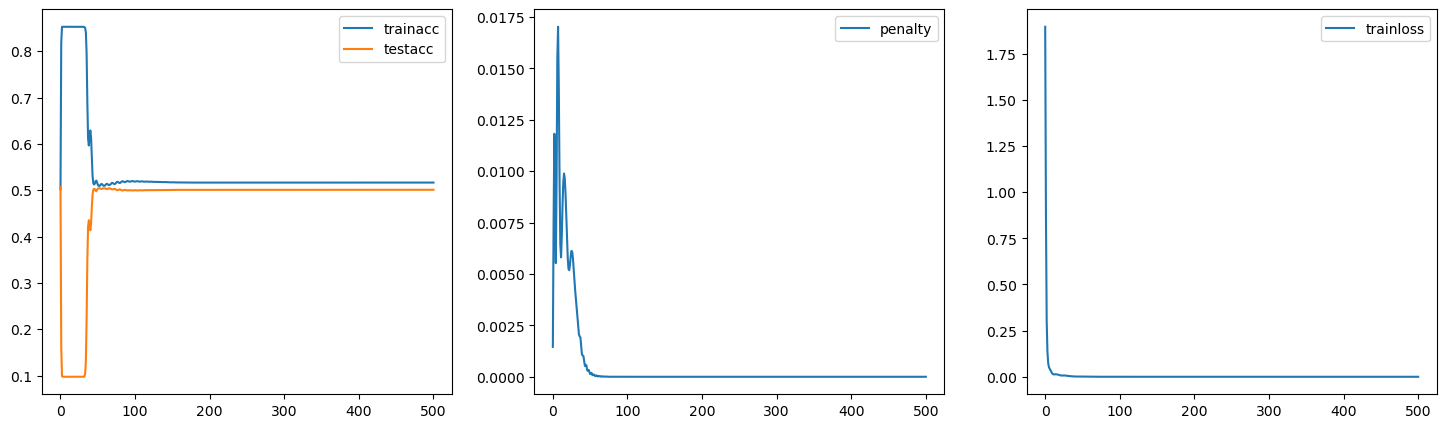

In [15]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=[18.0,5.0])
ax=plt.subplot(1,3,1)
ax.plot(trainacc,label='trainacc')
ax.plot(testacc,label='testacc')
ax.legend()
ax=plt.subplot(1,3,2)
ax.plot(penaltys,label='penalty')
ax.legend()
ax=plt.subplot(1,3,3)
ax.plot(allloss,label='trainloss')
ax.legend()
plt.show()


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to("cuda")).to("cpu")
        predicted = outputs.map_(outputs, lambda x, _: int(x > 0))
        predicted = predicted.reshape(10000)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy: %f " % (correct / total))

Accuracy: 0.498050 


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in train1loader:
        images, labels = data
        outputs = net(images.to("cuda")).to("cpu")
        predicted = outputs.map_(outputs, lambda x, _: int(x > 0))
        predicted = predicted.reshape(20000)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy: %f " % (correct / total))

Accuracy: 0.522400 
